# Pyem comparison

### Compare projection with the ``pyem.project`` function in [pyem](https://github.com/asarnow/pyem)
### Mainly to run sanity checks that the `simplecryoem` forward model works as expected.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
from jax import config
import jax.numpy as jnp

from pyem import star
from pyem import vop
from pyem.cli.project import project as project_pyem
from pyfftw.builders import irfft2

from simplecryoem.utils import volume_fourier, mip_x, mip_z
from simplecryoem.forwardmodel import project

2024-10-09 17:33:04.476957: W external/xla/xla/service/gpu/nvptx_compiler.cc:930] The NVIDIA driver's CUDA version is 12.5 which is older than the PTX compiler version 12.6.77. Because the driver is older than the PTX compiler version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [2]:
%load_ext autoreload
%autoreload 2

config.update("jax_enable_x64", True)
plt.rcParams["figure.figsize"] = 6, 6

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### The volume

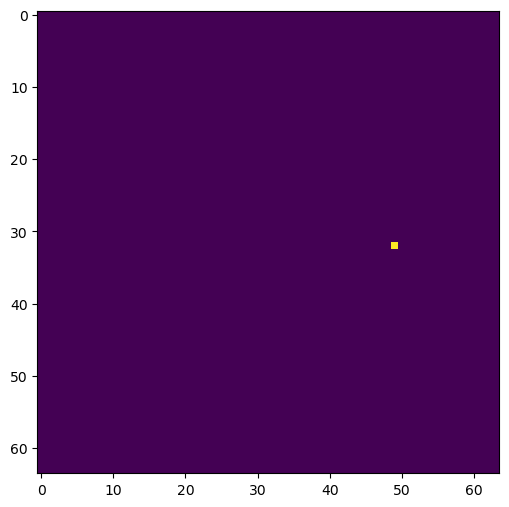

In [3]:
nx = 64
dx = 0.2

vol = np.zeros([nx, nx, nx])
vol[32, 49, 32] = 1

vol_pyem = np.zeros([nx, nx, nx])
vol_pyem[32, 32, 49] = 1

mip_x(vol_pyem)

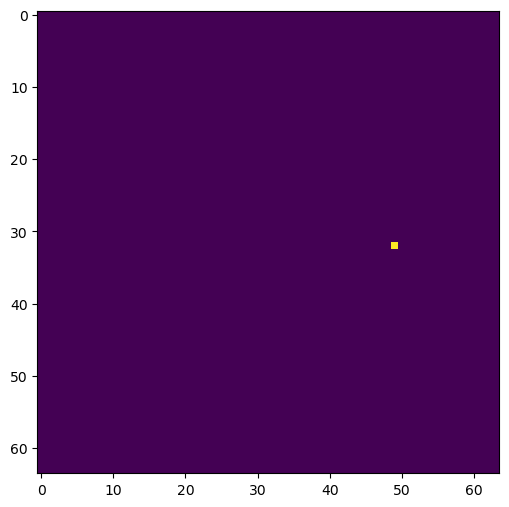

In [4]:
mip_z(vol)

In [5]:
# f3d : Fourier volume (centred, Nyquist-limited, zero-padded (pfac=2), normalized (normfft=1) interpolation-ready 3D Fourier transform)

pfac = 1
f3d_pyem = vop.vol_ft(vol_pyem, pfac=pfac, threads=1)
# plt.imshow(np.real(f3d_pyem[:,:,3])); plt.colorbar()

### Pyem projection

Parameters from the [Relion SPA tutorial](https://relion.readthedocs.io/en/release-3.1/SPA_tutorial/index.html).

In [6]:
df = star.parse_star("data/pyem.star", keep_index=False)
dfiter = df.iterrows()
i, p = next(dfiter)
# i, p = next(dfiter)

# p["rlnVoltage"] = 0
# p["rlnSphericalAberration"]
p[star.Relion.ORIGINX] = -11.4
p[star.Relion.ORIGINY] = 12.9

# These don't make any difference here. These replaced rlnOriginX and rlnOriginY (pixels) in Relion 3.1
# Setting to zero just in case.
p[star.Relion.ORIGINXANGST] = 0
p[star.Relion.ORIGINYANGST] = 0

p[star.Relion.ANGLEROT] = -30.0 # Around the z axis (first axis)
p[star.Relion.ANGLETILT] = 77.14285714285714 # Around the new y axis
p[star.Relion.ANGLEPSI] = -594.0 # Arond the new z axis

# p[star.Relion.ANGLEROT] = 0  # Around the z axis (first axis)
# p[star.Relion.ANGLETILT] = 0  # Around the new y axis
# p[star.Relion.ANGLEPSI] = 0  # Arond the new z axis

p["rlnSphericalAberration"] = 0
p["rlnAmplitudeContrast"] = 0

# p[star.Relion.DEFOCUSU] = 0
# p[star.Relion.DEFOCUSV] = 0
# p[star.Relion.DEFOCUSANGLE] = 0

In [7]:
# pfac = 2

size = (f3d_pyem.shape[0] - 3) // pfac
# size = 131

sz = (f3d_pyem.shape[0] - 3) // pfac
# sz = size
sx, sy = np.meshgrid(np.fft.rfftfreq(sz), np.fft.fftfreq(sz))
s = np.sqrt(sx**2 + sy**2)
a = np.arctan2(sy, sx)

f2d_pyem = project_pyem(
    f3d_pyem, p, s, sx, sy, a, pfac=pfac, apply_ctf=False, size=size, flip_phase=False
)


ift = irfft2(
    f2d_pyem.copy(),
    threads=1,
    planner_effort="FFTW_ESTIMATE",
    auto_align_input=True,
    auto_contiguous=True,
)
proj_pyem = np.fft.fftshift(
    ift(f2d_pyem.copy(), np.zeros(ift.output_shape, dtype=ift.output_dtype))
)

# plt.imshow(np.real(f2d_pyem)); plt.colorbar()
print(f2d_pyem.shape)

(64, 33)


### simplecryoem projection

In [8]:
# Pixel size - here we multiply by 64/66 to match the 'effective pixel size' in pyem,
# where the image is padded with 3 additional rows/columns (in addition to the padding)
pixel_size = star.calculate_apix(p) * 64.0 / 66.0

f3d, x_grid, _ = volume_fourier(vol, pixel_size)
y_grid = x_grid
z_grid = x_grid

# mymask = create_mask(X,Y,Z, (0,0,0), np.max(X))
# f3d = f3d * mymask

# third angle is rotation around the first z axis
angles = np.radians(np.array([p[star.Relion.ANGLEPSI], p[star.Relion.ANGLETILT], p[star.Relion.ANGLEROT]]))
shifts = jnp.array([p[star.Relion.ORIGINX], p[star.Relion.ORIGINY]]) * pixel_size

In [9]:
# ctf_params = {
#    "def1": p[star.Relion.DEFOCUSU],
#    "def2": p[star.Relion.DEFOCUSV],
#    "angast": p[star.Relion.DEFOCUSANGLE],
#    "phase": p[star.Relion.PHASESHIFT],
#    "kv": p[star.Relion.VOLTAGE],
#    "ac": p[star.Relion.AC],
#    "cs": p[star.Relion.CS],
#    "bf": 0,
#    "lp": 2 * pixel_size,
#}

ctf_params = [
    p[star.Relion.DEFOCUSU],
    p[star.Relion.DEFOCUSV],
    p[star.Relion.DEFOCUSANGLE],
     p[star.Relion.PHASESHIFT],
    p[star.Relion.VOLTAGE],
    p[star.Relion.AC],
    p[star.Relion.CS],
    0,
    2 * pixel_size,
]

In [10]:
f2d = project(f3d, angles, shifts, jnp.array([jnp.nan]), x_grid, x_grid, "tri")
f2d = f2d.reshape(f3d.shape[0], f3d.shape[1])
# f2d = np.fft.fftshift(f2d)

In [11]:
proj = np.real(np.fft.fftshift(np.fft.ifftn(f2d)))

In [12]:
np.sum(np.abs(np.imag(np.fft.fftshift(np.fft.ifftn(f2d)))))

3.995451464422077

### Compare

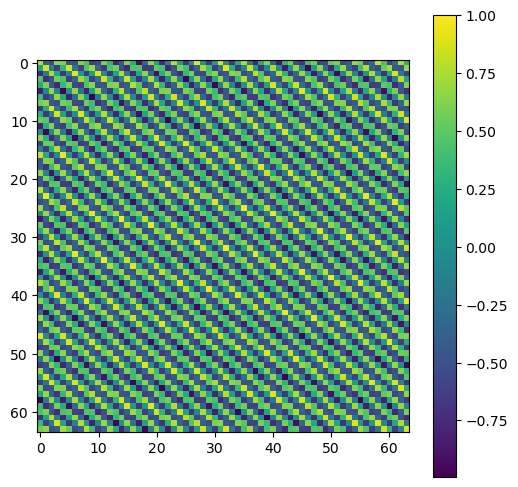

In [13]:
plt.imshow(np.fft.fftshift(np.real(f2d)))
plt.colorbar()

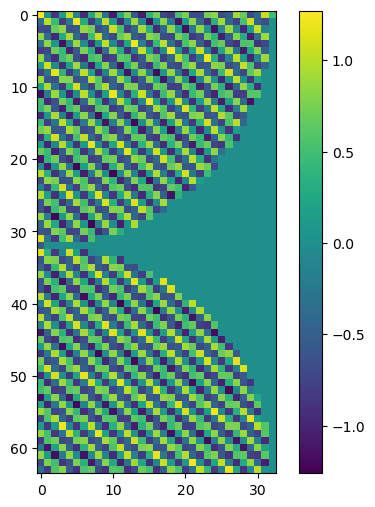

In [14]:
plt.imshow(np.real(f2d_pyem))
plt.colorbar()

In [15]:
# Compute the full FFT of the pyem object and fftshift.

f2d_pyem_full = np.zeros(f2d.shape, dtype=f2d_pyem.dtype)
f2d_pyem_full[:, 0:33] = f2d_pyem

for k1 in range(64):
    for k2 in range(32, 64):
        if k1 == 0:
            kk1 = 0
        else:
            kk1 = 64 - k1

        if k2 == 0:
            kk2 = 0
        else:
            kk2 = 64 - k2

        f2d_pyem_full[k1, k2] = np.conj(f2d_pyem[kk1, kk2])

0.7836393713951111

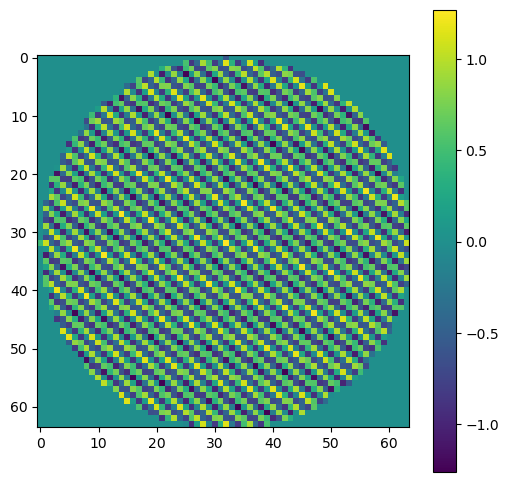

In [16]:
plt.imshow(np.real(np.fft.fftshift(f2d_pyem_full)))
plt.colorbar()
np.sum(np.abs(np.imag(np.fft.fftshift(np.fft.ifftn(f2d_pyem_full)))))

In [17]:
fs = np.fft.fftshift(f2d)
fs[0, 0]

(0.7756532374649071-0.4980154918455603j)

1.438688899740566


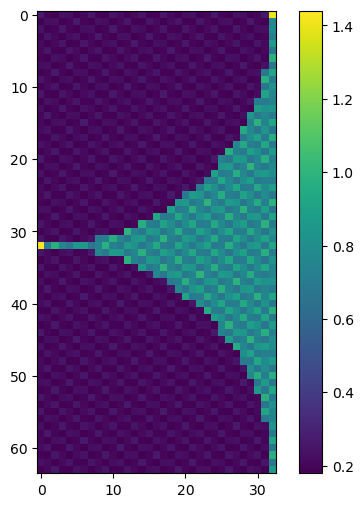

In [18]:
diff = np.array(f2d[:, 0:33] - f2d_pyem)

plt.imshow(np.abs(diff))
plt.colorbar()
print(np.max(np.abs(diff)))

0.26840662956237793


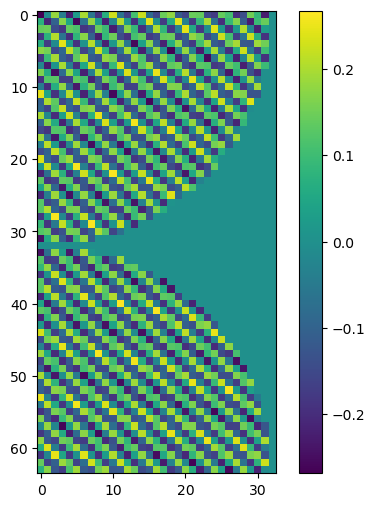

In [19]:
diff[np.abs(diff) > 0.6] = 0
plt.imshow(np.real(diff))
plt.colorbar()

print(np.max(np.abs(diff)))

1.438688899740566


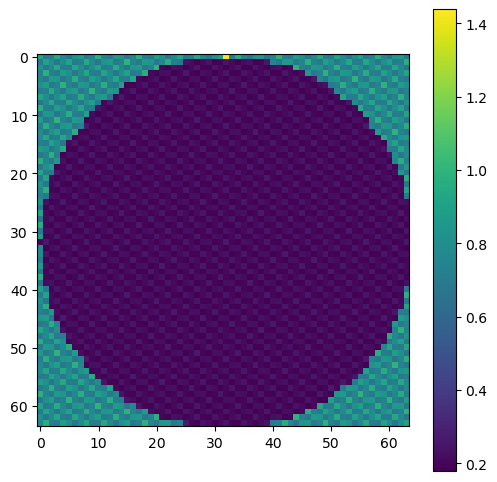

In [20]:
diff_full = np.array(f2d - f2d_pyem_full)

plt.imshow(np.abs(np.fft.fftshift(diff_full)))
plt.colorbar()
print(np.max(np.abs(diff_full)))

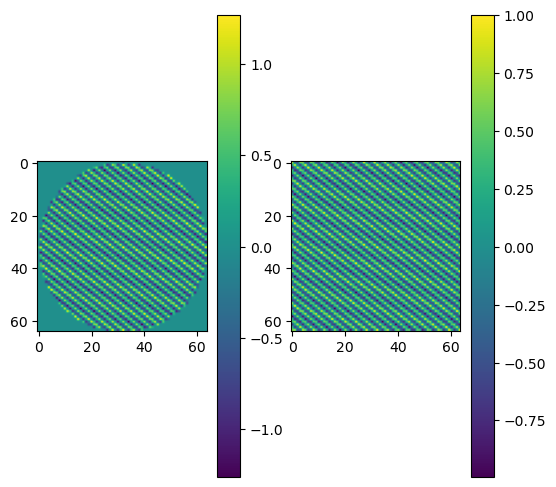

In [21]:
plt.subplot(1, 2, 1)
plt.imshow(np.real(np.fft.fftshift(f2d_pyem_full)))
plt.colorbar()
plt.subplot(1, 2, 2)
plt.imshow(np.fft.fftshift(np.real(f2d)))
plt.colorbar()

0.26840662956237793


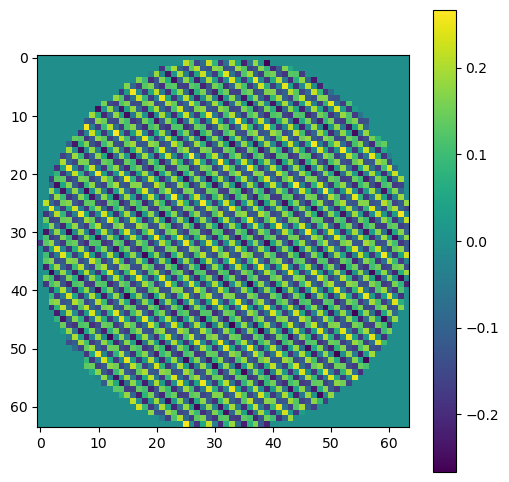

In [22]:
diff_full[np.abs(diff_full) > 0.6] = 0
plt.imshow(np.imag(np.fft.fftshift(diff_full)))
plt.colorbar()

print(np.max(np.abs(diff_full)))

In [23]:
diff_full_shifted = np.fft.fftshift(diff_full)
f2d_shifted = np.fft.fftshift(f2d)
f2d_pyem_full_shifted = np.fft.fftshift(f2d_pyem_full)

d = np.zeros(64, dtype=np.complex128)
f = np.zeros(64, dtype=np.complex128)
fpyem = np.zeros(64, dtype=np.complex128)
for i in range(64):
    d[i] = diff_full_shifted[63 - i, i]
    f[i] = f2d_shifted[63 - i, i]
    fpyem[i] = f2d_pyem_full_shifted[63 - i, i]

In [24]:
f2d0 = np.fft.fftshift(f2d)
f0 = f2d[0, :]

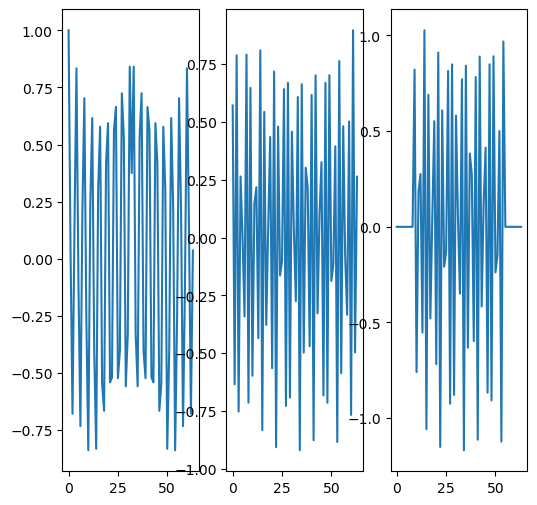

In [25]:
plt.subplot(1, 3, 1)
plt.plot(np.real(f0))
plt.subplot(1, 3, 2)
plt.plot(np.real(f))
plt.subplot(1, 3, 3)
plt.plot(np.real(fpyem))

### The `pyEM` projection as given by FFTW using irfft

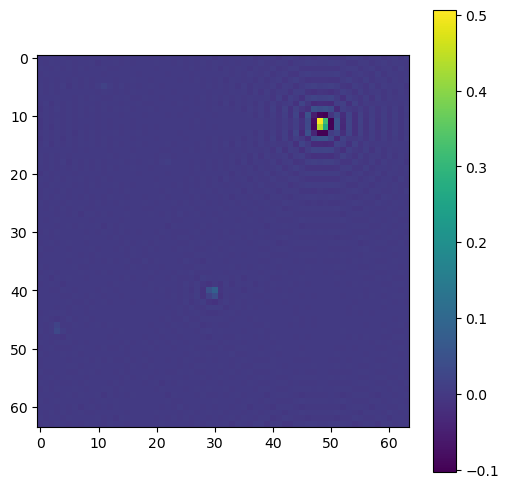

In [26]:
plt.imshow(proj_pyem)
plt.colorbar()

### The projection using `simplecryoem`

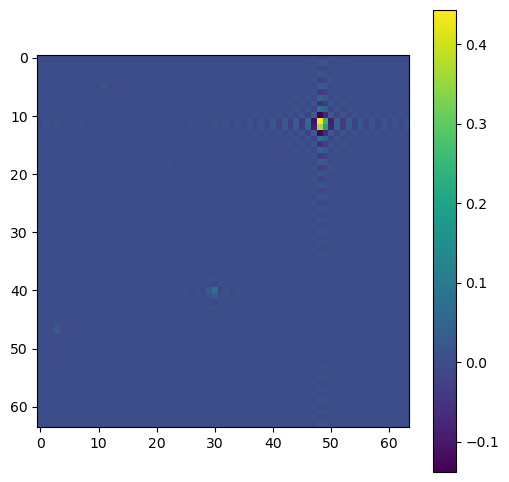

In [27]:
plt.imshow(proj)
plt.colorbar()

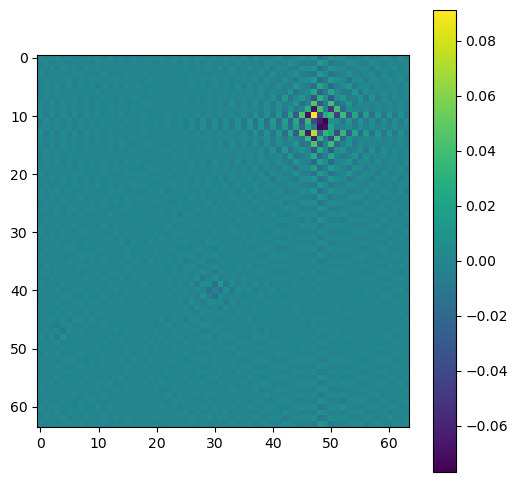

In [28]:
plt.imshow(proj - proj_pyem)
plt.colorbar()

### Projection using the pyEM Fourier slice + manual completion of the fft + numpy ifft

In [29]:
proj_pyem_full = np.fft.fftshift(np.fft.ifftn(f2d_pyem_full))

print(np.sum(np.abs(np.imag(proj_pyem_full))))

# proj_pyem_full = np.real(proj_pyem_full)

0.7836393713951111


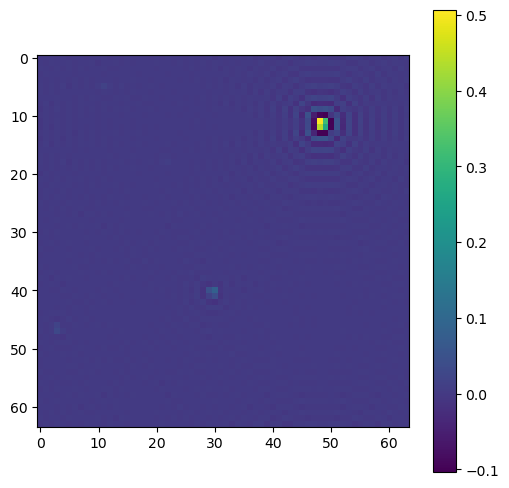

In [30]:
plt.imshow(np.real(proj_pyem_full))
plt.colorbar()

### Sanity check - the pyEM projection agrees with the completed pyEM slice

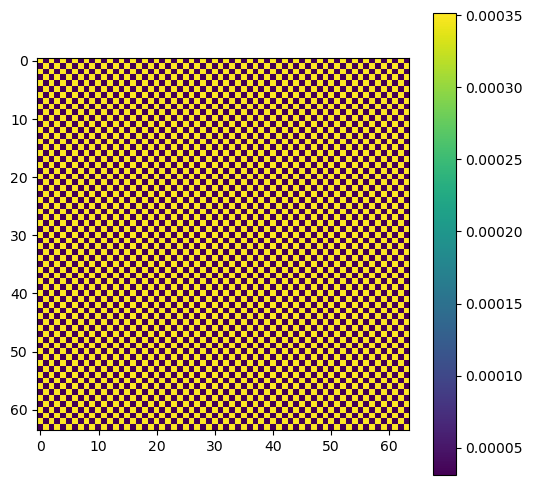

In [31]:
plt.imshow(np.abs(proj_pyem.astype(np.complex128) - proj_pyem_full))
plt.colorbar()